In [1]:
'''# Run this cell to install compatible versions of package

!pip uninstall -y numpy tensorflow tensorflow-gpu ml_dtypes gensim

!pip install numpy==1.23.5  
!pip install gensim==4.3.0
!pip install tensorflow==2.19.0

# Force restart the kernel after installing packages
print("Please restart the kernel after running this cell.")'''

'# Run this cell to install compatible versions of package\n\n!pip uninstall -y numpy tensorflow tensorflow-gpu ml_dtypes gensim\n\n!pip install numpy==1.23.5  \n!pip install gensim==4.3.0\n!pip install tensorflow==2.19.0\n\n# Force restart the kernel after installing packages\nprint("Please restart the kernel after running this cell.")'

# Semantic Text Similarity
Este modelo utiliza gensim para convertir pares de vectores + puntuacions en vectores (word embeddings).
Dado un dataset, infere la puntuació de similitud entre ambdues frases.

In [2]:
import os
# Requisits
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Import our custom functions
from Functions import *

In [3]:
# Tipat
from typing import Tuple, List, Optional

In [4]:
# Models pre-entrenats
# WV_MODEL_PATH = "/Users/salva/Downloads/cc.ca.300.bin.gz"


'''WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'
import gensim
wv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)
wv_model'''

"WV_MODEL_PATH = '/Users/salva/Downloads/cc.ca.300.vec.gz'\nimport gensim\nwv_model =  gensim.models.KeyedVectors.load_word2vec_format(WV_MODEL_PATH, binary=False)\nwv_model"

In [5]:
# Llavors podeu carregar el model com a mmap
from gensim.models.fasttext import FastTextKeyedVectors
wv_model = FastTextKeyedVectors.load('../cc.ca.gensim.bin', mmap='r')

In [6]:
REMAP_EMBEDDINGS: bool = True
USE_PRETRAINED: bool = True

In [7]:
from datasets import load_dataset
# Text Similarity (STS) dataset (principal per la Pràctica 4)
train = load_dataset("projecte-aina/sts-ca", split="train")
test = load_dataset("projecte-aina/sts-ca", split="test")
val = load_dataset("projecte-aina/sts-ca", split="validation")

all_data = load_dataset("projecte-aina/sts-ca", split="all")
print(f"Train: {len(train)} samples, Validation: {len(val)} samples, Test: {len(test)} samples")
all_data

C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train: 2073 samples, Validation: 500 samples, Test: 500 samples


Dataset({
    features: ['id', 'sentence_1', 'sentence_2', 'label'],
    num_rows: 3073
})

In [8]:
# Process each dataset
sentences_1_preproc, sentences_2_preproc, scores, sentence_pairs = map_corpus(all_data)

# Optionally process train/test/val sets separately
train_s1, train_s2, train_scores, train_pairs = map_corpus(train)
test_s1, test_s2, test_scores, test_pairs = map_corpus(test)
val_s1, val_s2, val_scores, val_pairs = map_corpus(val)

## Generacion del diccionario de todo el corpus existent per a aquest problema

In [9]:
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)
diccionario

## Alternative Baseline : One-Hot Encoding

Una altra alternativa és utilitzar One-Hot Encoding per representar les frases. Això pot ser útil per comparar la similitud entre frases de manera més directa, encara que no captura la semàntica de les paraules com ho fan els word embeddings. La similitud es pot calcular fent servir la distància de Jaccard (número de paraules en comú dividit entre número de paraules totals entre les dues frases) o el coseno entre els vectors resultants.

In [10]:
# Evaluate using Jaccard similarity
train_jaccard_scores = one_hot_evaluation(train_s1, train_s2)
val_jaccard_scores = one_hot_evaluation(val_s1, val_s2)
test_jaccard_scores = one_hot_evaluation(test_s1, test_s2)

# Convert to numpy arrays for proper comparison
train_jaccard_scores = np.array(train_jaccard_scores)
val_jaccard_scores = np.array(val_jaccard_scores)
test_jaccard_scores = np.array(test_jaccard_scores)

# Calculate Pearson correlations
train_correlation_jaccard, _ = pearsonr(train_jaccard_scores, train_scores)
val_correlation_jaccard, _ = pearsonr(val_jaccard_scores, val_scores)
test_correlation_jaccard, _ = pearsonr(test_jaccard_scores, test_scores)

print(f"Jaccard Similarity Pearson Correlations:")
print(f"Train: {train_correlation_jaccard:.4f}")
print(f"Validation: {val_correlation_jaccard:.4f}")
print(f"Test: {test_correlation_jaccard:.4f}")

Jaccard Similarity Pearson Correlations:
Train: 0.5417
Validation: 0.5002
Test: 0.6187


In [11]:
# Evaluate using Cosine similarity with one-hot encoding
train_cosine_scores = one_hot_cosine_similarity(train_s1, train_s2, diccionario)
val_cosine_scores = one_hot_cosine_similarity(val_s1, val_s2, diccionario)
test_cosine_scores = one_hot_cosine_similarity(test_s1, test_s2, diccionario)

# Convert to numpy arrays
train_cosine_scores = np.array(train_cosine_scores)
val_cosine_scores = np.array(val_cosine_scores)
test_cosine_scores = np.array(test_cosine_scores)

# Calculate Pearson correlations
train_correlation_cosine, _ = pearsonr(train_cosine_scores, train_scores)
val_correlation_cosine, _ = pearsonr(val_cosine_scores, val_scores)
test_correlation_cosine, _ = pearsonr(test_cosine_scores, test_scores)

print(f"One-Hot Cosine Similarity Pearson Correlations:")
print(f"Train: {train_correlation_cosine:.4f}")
print(f"Validation: {val_correlation_cosine:.4f}")
print(f"Test: {test_correlation_cosine:.4f}")

One-Hot Cosine Similarity Pearson Correlations:
Train: 0.5520
Validation: 0.5075
Test: 0.6275


## Modelo regressió amb atenció

In [12]:
print("Max Len:", max([len(s) for s in sentences_1_preproc]), max([len(s) for s in sentences_2_preproc]))
print(list(diccionario.doc2idx(sentences_1_preproc[0])))

Max Len: 30 30
[0, 11, 13, 1, 9, 10, 5, 14, 8, 7, 2, 8, 12, 2, 6, 4, 3, 15]


In [13]:
# Map sentence pairs to vectors using the word embeddings
mapped = map_pairs(sentence_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)
print(mapped[0])

((array([ 1, 12, 14,  2, 10, 11,  6, 15,  9,  8,  3,  9, 13,  3,  7,  5,  4,
       16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([10010,     9,  2784,     6,    15,     9,     8,     3,     9,
          13,     3,     7,     5,     4,    16,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])), 3.5)


In [14]:
# Definir constants d'entrenament
batch_size: int = 64
num_epochs: int = 128
# train_val_split variable is no longer needed since we're using the predefined splits

In [15]:
len(mapped)

3073

In [16]:
# Process each dataset separately
# Map train, val, and test sets to word embeddings
train_mapped = map_pairs(train_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)
val_mapped = map_pairs(val_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)
test_mapped = map_pairs(test_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None, wv_model=wv_model)

# Obtener las listas de train, val i test
x_train, y_train = pair_list_to_x_y(train_mapped)
x_val, y_val = pair_list_to_x_y(val_mapped)
x_test, y_test = pair_list_to_x_y(test_mapped)

print(f"Train shapes: {x_train[0].shape}, {x_train[1].shape}, {y_train.shape}")
print(f"Validation shapes: {x_val[0].shape}, {x_val[1].shape}, {y_val.shape}")
print(f"Test shapes: {x_test[0].shape}, {x_test[1].shape}, {y_test.shape}")

Train shapes: (2073, 32), (2073, 32), (2073,)
Validation shapes: (500, 32), (500, 32), (500,)
Test shapes: (500, 32), (500, 32), (500,)

Validation shapes: (500, 32), (500, 32), (500,)
Test shapes: (500, 32), (500, 32), (500,)


In [17]:
# Check if TensorFlow is properly installed and handle compatibility issues with NumPy
import tensorflow as tf

# Now prepare the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train[0])).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print(f"Batches in train_dataset: {len(list(train_dataset))}")
print(f"Batches in val_dataset: {len(list(val_dataset))}")
print(f"Batches in test_dataset: {len(list(test_dataset))}")

Batches in train_dataset: 33
Batches in val_dataset: 8
Batches in test_dataset: 8


In [18]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [19]:
pretrained_weights: Optional[np.ndarray] = None
if USE_PRETRAINED:
    if REMAP_EMBEDDINGS:
        pretrained_weights = np.zeros(
            (len(diccionario.token2id) + 1, wv_model.vector_size),  dtype=np.float32)
        for token, _id in diccionario.token2id.items():
            if token in wv_model:
                pretrained_weights[_id + 1] = wv_model[token]
            else:
                # In W2V, OOV will not have a representation. We will use 0.
                pass
    else:
        # Not recommended (this will consume A LOT of RAM) PORQUE CARGA TODOS LOS VECTORES DEL MODELO.
        pretrained_weights = np.zeros((wv_model.vectors.shape[0] + 1, wv_model.vector_size,),  dtype=np.float32)
        pretrained_weights[1:, :] = wv_model.vectors

In [20]:
pretrained_weights[:5]

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-0.0307,  0.0032,  0.0128, ..., -0.0154,  0.0374,  0.0234],
       [ 0.0519, -0.0079, -0.0013, ..., -0.0154, -0.0353, -0.0235],
       [ 0.0058, -0.0161,  0.062 , ...,  0.0129,  0.019 ,  0.0177],
       [-0.042 , -0.0113,  0.0837, ..., -0.0396, -0.0253, -0.0045]],
      dtype=float32)

In [21]:
# Construir i compilar el model
model = build_and_compile_model_2(pretrained_weights=pretrained_weights, learning_rate=1e-3)
# Entrenar el model
model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/128
Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1244 - mae: 0.3149 - val_loss: 0.1562 - val_mae: 0.3533
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1244 - mae: 0.3149 - val_loss: 0.1562 - val_mae: 0.3533
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0880 - mae: 0.2560 - val_loss: 0.1405 - val_mae: 0.3275
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0880 - mae: 0.2560 - val_loss: 0.1405 - val_mae: 0.3275
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0735 - mae: 0.2287 - val_loss: 0.1341 - val_mae: 0.3197
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0735 - mae: 0.2287 - val_loss: 0.1341 - val_mae: 0.3197
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0683 - mae: 0.2189 - val_loss: 0.1295 - val_mae: 0.3150
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0683 - mae: 0.2189 - val_loss: 0.1295 - val_mae: 0.3150
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [22]:
model.summary()

Model: "sequence_similarity_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_pretrain… │ (None, 32, 300)   │  3,937,800 │ input_1[0][0],    │
│ (Embedding)         │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_1[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 32)        │          0 │ input_2[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_attention  │ (None, 300)       │      1,208 │ embedding_pretra… │
│ (SimpleAttention)   │                   │            │ not_equal[0][0],  │
│                     │                   │            │ embedding_pretra… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_layer    │ (None, 300)       │     90,300 │ sentence_attenti… │
│ (Dense)             │                   │            │ sentence_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ projection_dropout  │ (None, 300)       │          0 │ projection_layer… │
│ (Dropout)           │                   │            │ projection_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_1         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalize_2         │ (None, 300)       │          0 │ projection_dropo… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ normalize_1[0][0… │
│ (Lambda)            │                   │            │ normalize_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_scaling      │ (None, 1)         │          0 │ cosine_similarit… │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,212,326 (16.07 MB)

 Trainable params: 91,508 (357.45 KB)

 Non-trainable params: 3,937,800 (15.02 MB)

 Optimizer params: 183,018 (714.92 KB)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


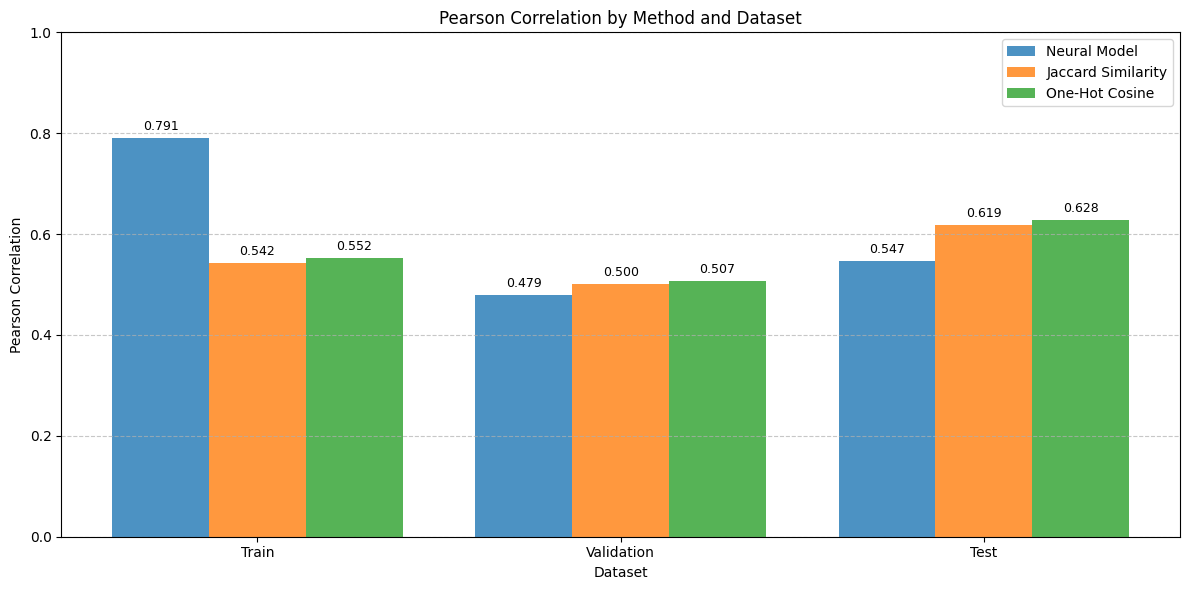

In [23]:
# Store the baseline method results for the visualization
baseline_methods = {
    'Jaccard Similarity': {
        'Train': train_correlation_jaccard,
        'Validation': val_correlation_jaccard,
        'Test': test_correlation_jaccard
    },
    'One-Hot Cosine': {
        'Train': train_correlation_cosine,
        'Validation': val_correlation_cosine,
        'Test': test_correlation_cosine
    }
}

# Visualize the Pearson correlations
visualize_pearson_correlations(
    model=model,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=baseline_methods
)

In [24]:
# Evaluate neural model on validation set
y_pred_val = model.predict(x_val)
correlation_val, _ = pearsonr(y_pred_val.flatten(), y_val.flatten())
print(f"Neural Model Validation Pearson Correlation: {correlation_val:.4f}")

# Evaluate neural model on training set
y_pred_train = model.predict(x_train)
correlation_train, _ = pearsonr(y_pred_train.flatten(), y_train.flatten())
print(f"Neural Model Training Pearson Correlation: {correlation_train:.4f}")

# Evaluate neural model on test set
y_pred_test = model.predict(x_test)
correlation_test, _ = pearsonr(y_pred_test.flatten(), y_test.flatten())
print(f"Neural Model Test Pearson Correlation: {correlation_test:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Neural Model Validation Pearson Correlation: 0.4793
 1/65 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/stepNeural Model Validation Pearson Correlation: 0.4793
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Model Training Pearson Correlation: 0.7907
Neural Model Training Pearson Correlation: 0.7907
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Model Test Pearson Correlation: 0.5469
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Model Test Pearson Correlation: 0.5469


In [25]:
tf.__version__

'2.19.0'

## Experimentació amb embeddings aleatoris

Per entendre millor l'impacte dels embeddings preentrenats, anem a entrenar el model amb embeddings aleatoris inicialitzats per veure quina és la seva capacitat d'aprenentatge sense el coneixement previ.

In [30]:
# Construir i compilar el model amb embeddings aleatoris (sense pretrained_weights)
random_emb_model = build_and_compile_model_2(
    input_length=32,
    dictionary_size=len(diccionario.token2id) + 1,  # +1 per padding
    embedding_size=300,
    pretrained_weights=None,  # Aquí la clau: no utilitzem embeddings preentrenats
    trainable_embedding=True,  # Els embeddings han de ser entrenables
    learning_rate=1e-3,
    attention_units=4
)

# Crear un callback per early stopping per evitar sobreentrenament
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entrenar el model
print("Entrenant model amb embeddings aleatoris...")
history_random = random_emb_model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Avaluar el model
random_train_pred = random_emb_model.predict(x_train)
random_val_pred = random_emb_model.predict(x_val)
random_test_pred = random_emb_model.predict(x_test)

random_train_corr, _ = pearsonr(random_train_pred.flatten(), y_train.flatten())
random_val_corr, _ = pearsonr(random_val_pred.flatten(), y_val.flatten())
random_test_corr, _ = pearsonr(random_test_pred.flatten(), y_test.flatten())

print(f"Model amb embeddings aleatoris - Pearson Correlations:")
print(f"Training: {random_train_corr:.4f}")
print(f"Validation: {random_val_corr:.4f}")
print(f"Test: {random_test_corr:.4f}")

Entrenant model amb embeddings aleatoris...
Epoch 1/128


C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0674 - mae: 0.2309 - val_loss: 0.0857 - val_mae: 0.2603
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0674 - mae: 0.2309 - val_loss: 0.0857 - val_mae: 0.2603
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0330 - mae: 0.1511 - val_loss: 0.0795 - val_mae: 0.2491
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0330 - mae: 0.1511 - val_loss: 0.0795 - val_mae: 0.2491
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0120 - mae: 0.0815 - val_loss: 0.0778 - val_mae: 0.2456
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0120 - mae: 0.0815 - val_loss: 0.0778 - val_mae: 0.2456
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0065 - mae: 0.0593 - val_loss: 0.0781 - val_mae: 0.2467
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0065 - mae: 0.0593 - val_loss: 0.0781 - val_mae: 0.2467
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0058 -

## Experimentació amb diferents dimensions de embeddings

Per estudiar com varia la capacitat del model segons la mida dels word embeddings, crearem versions reduïdes dels embeddings amb diferents dimensions (50, 100, 150) i compararem el seu rendiment.

In [26]:
# Crear versions reduïdes de los word embeddings
reduced_models = create_reduced_embeddings(wv_model)

# Verificar alguns vectores per confirmar que la reducció funciona
for dim in reduced_models:
    print(f"\nDimensión {dim}:")
    test_word = "casa" if "casa" in wv_model else wv_model.index_to_key[0]
    print(f"Palabra '{test_word}' - Vector: {reduced_models[dim][test_word][:5]}... (forma: {reduced_models[dim][test_word].shape})")

Creando versiones reducidas de los embeddings (2000000 palabras)...
Creando modelo de 50 dimensiones...
Modelo de 50d creado. Ejemplo: 'casa' tiene forma (50,)
Creando modelo de 100 dimensiones...
Modelo de 50d creado. Ejemplo: 'casa' tiene forma (50,)
Creando modelo de 100 dimensiones...
Modelo de 100d creado. Ejemplo: 'casa' tiene forma (100,)
Creando modelo de 150 dimensiones...
Modelo de 100d creado. Ejemplo: 'casa' tiene forma (100,)
Creando modelo de 150 dimensiones...
Modelo de 150d creado. Ejemplo: 'casa' tiene forma (150,)
Tiempo total para crear modelos reducidos: 36.51 segundos

Dimensión 50:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (50,))

Dimensión 100:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (100,))

Dimensión 150:
Palabra 'casa' - Vector: [-0.0359 -0.0161 -0.0268  0.0022 -0.0873]... (forma: (150,))
Modelo de 150d creado. Ejemplo: 'casa' tiene forma (150,)
Tiempo total para crear modelos reducidos:


Entrenando modelo con embeddings de 50 dimensiones...


C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1723 - mae: 0.3605 - val_loss: 0.2253 - val_mae: 0.4444
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1723 - mae: 0.3605 - val_loss: 0.2253 - val_mae: 0.4444
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1428 - mae: 0.3283 - val_loss: 0.1687 - val_mae: 0.3696
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1428 - mae: 0.3283 - val_loss: 0.1687 - val_mae: 0.3696
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0933 - mae: 0.2602 - val_loss: 0.1372 - val_mae: 0.3256
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0933 - mae: 0.2602 - val_loss: 0.1372 - val_mae: 0.3256
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0631 - mae: 0.2083 - val_loss: 0.1302 - val_mae: 0.3196
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0631 - mae: 0.2083 - val_loss: 0.1302 - val_mae: 0.3196
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

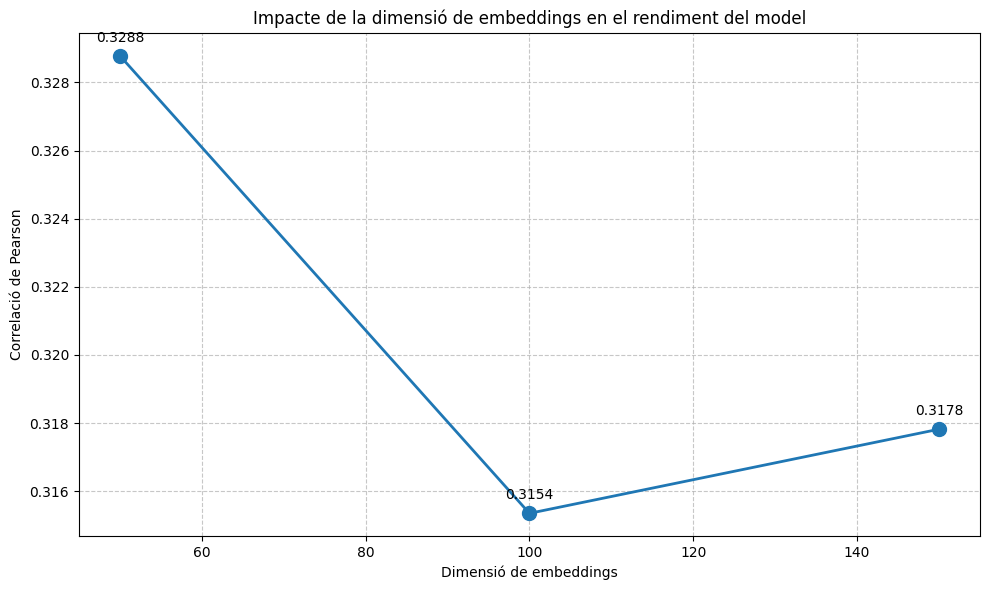

In [27]:
results = build_and_compile_model_with_reduced_embeddings(
    reduced_models, 
    train_dataset, 
    val_dataset, 
    diccionario, 
    num_epochs,
    x_val,
    y_val
)

# Print results summary
print("\n--- Resumen de resultados per dimensió ---")
for dim in reduced_models:
    print(f"Dimensió {dim}: Correlació de Pearson = {results[dim]:.4f}")

# Create a visualization for the dimension experiment
plt.figure(figsize=(10, 6))
dimensions = list(results.keys())
correlations = [results[dim] for dim in dimensions]

plt.plot(dimensions, correlations, marker='o', linewidth=2, markersize=10)
plt.xlabel('Dimensió de embeddings')
plt.ylabel('Correlació de Pearson')
plt.title('Impacte de la dimensió de embeddings en el rendiment del model')
plt.grid(True, linestyle='--', alpha=0.7)

# Add value annotations
for i, dim in enumerate(dimensions):
    plt.annotate(f'{correlations[i]:.4f}', 
                xy=(dim, correlations[i]), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center')

plt.tight_layout()
plt.show()

Epoch 1/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1360 - mae: 0.3321 - val_loss: 0.1502 - val_mae: 0.3495
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1360 - mae: 0.3321 - val_loss: 0.1502 - val_mae: 0.3495
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0991 - mae: 0.2805 - val_loss: 0.1345 - val_mae: 0.3255
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0991 - mae: 0.2805 - val_loss: 0.1345 - val_mae: 0.3255
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0867 - mae: 0.2591 - val_loss: 0.1299 - val_mae: 0.3178
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0867 - mae: 0.2591 - val_loss: 0.1299 - val_mae: 0.3178
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0796 - mae: 0.2474 - val_loss: 0.1254 - val_mae: 0.3110
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0796 - mae: 0.2474 - val_loss: 0.1254 - val_mae: 0.3110
Epoch 5/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

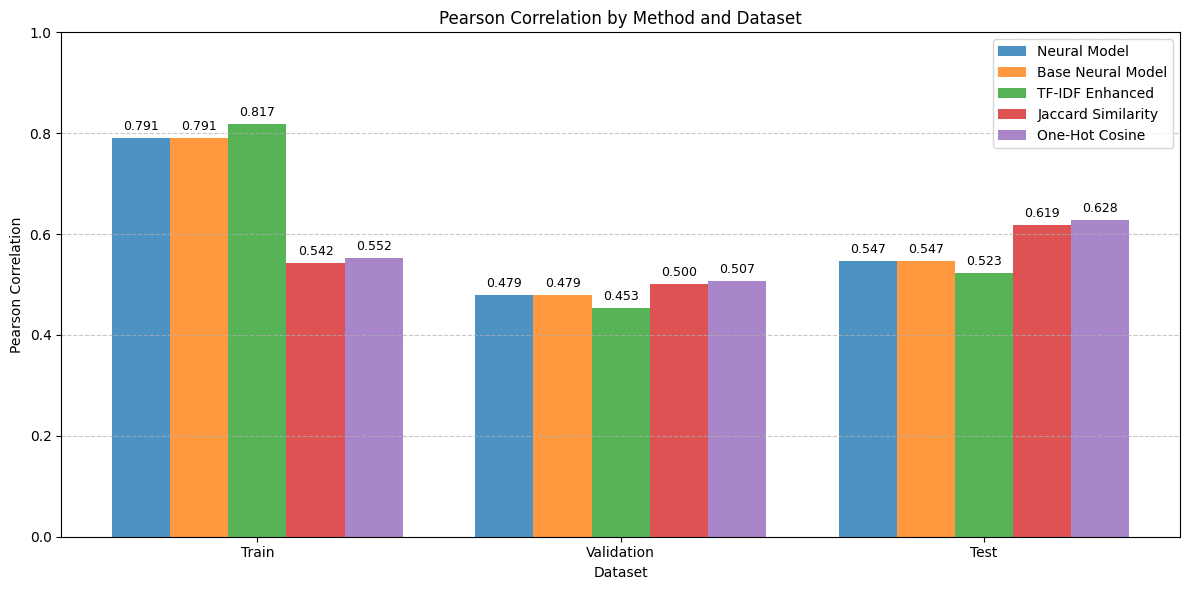

In [28]:
# Build and train the TF-IDF enhanced model
sentences = sentences_1_preproc + sentences_2_preproc

tfidf_model = build_tfidf_enhanced_model(
    pretrained_weights=pretrained_weights,
    learning_rate=1e-3,
    sentences=sentences,
    dictionary=diccionario if REMAP_EMBEDDINGS else None
)

# Train with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tfidf_model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluate TF-IDF model
tfidf_val_predictions = tfidf_model.predict(x_val)
tfidf_correlation_val, _ = pearsonr(tfidf_val_predictions.flatten(), y_val.flatten())

tfidf_train_predictions = tfidf_model.predict(x_train)
tfidf_correlation_train, _ = pearsonr(tfidf_train_predictions.flatten(), y_train.flatten())

tfidf_test_predictions = tfidf_model.predict(x_test)
tfidf_correlation_test, _ = pearsonr(tfidf_test_predictions.flatten(), y_test.flatten())

print(f"TF-IDF Enhanced Model Pearson Correlations:")
print(f"Training: {tfidf_correlation_train:.4f}")
print(f"Validation: {tfidf_correlation_val:.4f}")
print(f"Test: {tfidf_correlation_test:.4f}")

# Compare TF-IDF model with base model
methods_comparison = {
    'Base Neural Model': {
        'Train': correlation_train,
        'Validation': correlation_val,
        'Test': correlation_test
    },
    'TF-IDF Enhanced': {
        'Train': tfidf_correlation_train,
        'Validation': tfidf_correlation_val,
        'Test': tfidf_correlation_test
    },
    'Jaccard Similarity': {
        'Train': train_correlation_jaccard,
        'Validation': val_correlation_jaccard,
        'Test': test_correlation_jaccard
    },
    'One-Hot Cosine': {
        'Train': train_correlation_cosine,
        'Validation': val_correlation_cosine,
        'Test': test_correlation_cosine
    }
}

# Visualize all method comparisons
visualize_pearson_correlations(
    model=model,  # Doesn't matter which model we pass here since we're providing all data
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=methods_comparison
)

Epoch 1/128


C:\Users\jiahu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0299 - mae: 0.1369 - val_loss: 0.0286 - val_mae: 0.1308 - learning_rate: 5.0000e-04
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0299 - mae: 0.1369 - val_loss: 0.0286 - val_mae: 0.1308 - learning_rate: 5.0000e-04
Epoch 2/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.0263 - mae: 0.1275 - val_loss: 0.0280 - val_mae: 0.1288 - learning_rate: 5.0000e-04
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.0263 - mae: 0.1275 - val_loss: 0.0280 - val_mae: 0.1288 - learning_rate: 5.0000e-04
Epoch 3/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0267 - mae: 0.1269 - val_loss: 0.0276 - val_mae: 0.1269 - learning_rate: 5.0000e-04
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0267 - mae: 0.1269 - val_loss: 0.0276 - val_mae: 0.1269 - learning_rate: 5.0000e-04
Epoch 4/128
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - loss: 0.0262 - mae: 0.1247 - val_loss: 0.0270 - val_mae: 0.1257 - learn

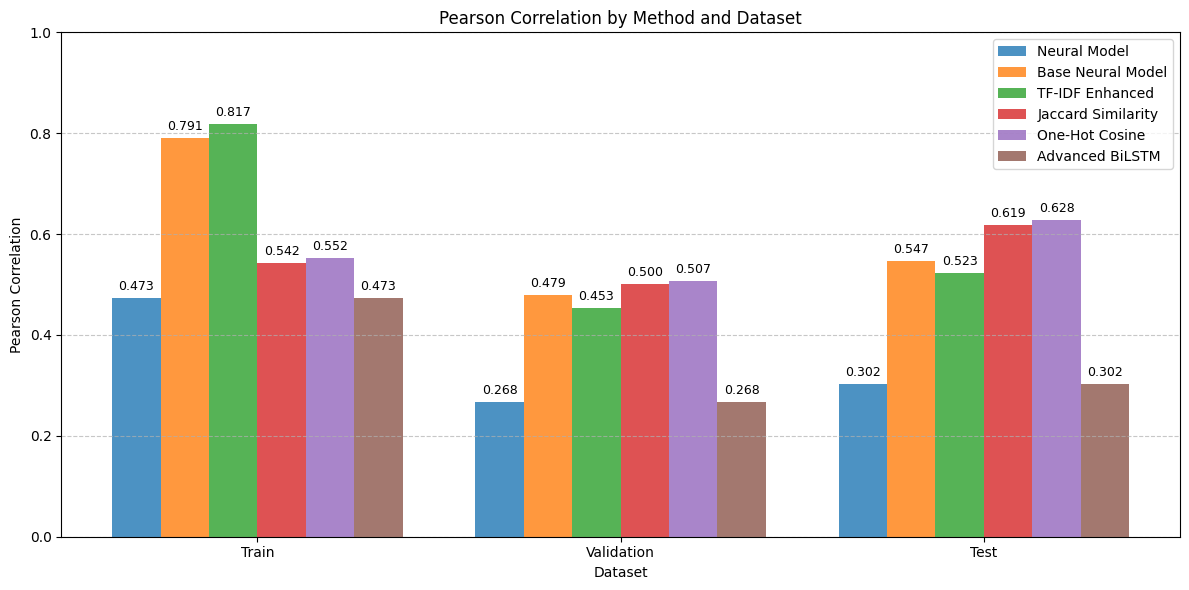

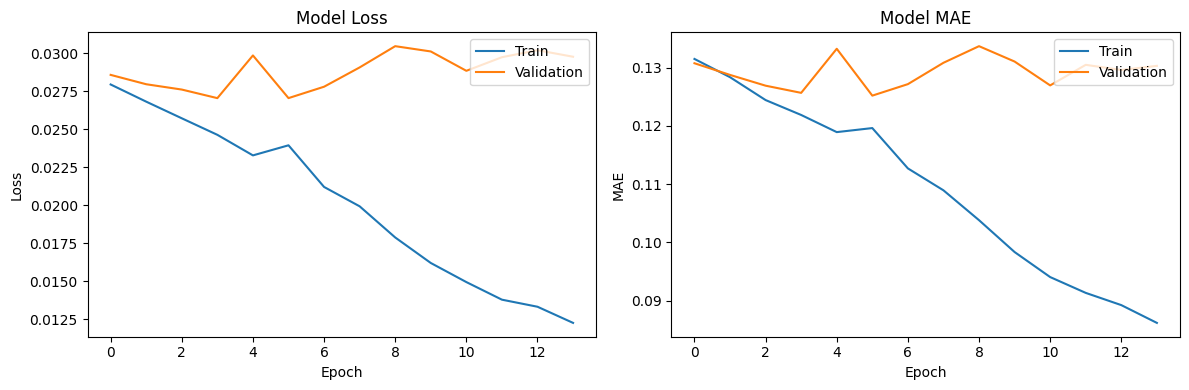

In [29]:
# Build the advanced BiLSTM model
advanced_model = build_simplified_advanced_model(
    pretrained_weights=pretrained_weights,
    learning_rate=5e-4,
    rnn_units=128,
    dropout_rate=0.15
)

# Train with early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = advanced_model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the advanced model
adv_train_pred = advanced_model.predict(x_train)
adv_val_pred = advanced_model.predict(x_val)
adv_test_pred = advanced_model.predict(x_test)

adv_train_corr, _ = pearsonr(adv_train_pred.flatten(), y_train.flatten())
adv_val_corr, _ = pearsonr(adv_val_pred.flatten(), y_val.flatten())
adv_test_corr, _ = pearsonr(adv_test_pred.flatten(), y_test.flatten())

print(f"Advanced BiLSTM Model Pearson Correlations:")
print(f"Training: {adv_train_corr:.4f}")
print(f"Validation: {adv_val_corr:.4f}")
print(f"Test: {adv_test_corr:.4f}")

# Update the methods comparison to include the advanced model
methods_comparison['Advanced BiLSTM'] = {
    'Train': adv_train_corr,
    'Validation': adv_val_corr,
    'Test': adv_test_corr
}

# Visualize the final comparison of all methods
visualize_pearson_correlations(
    model=advanced_model,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=methods_comparison
)

# Visualize the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Comparar resultats amb els models preentrenats
methods_comparison_with_random = {
    'Pretrained Embeddings': {
        'Train': correlation_train,
        'Validation': correlation_val,
        'Test': correlation_test
    },
    'Random Embeddings': {
        'Train': random_train_corr,
        'Validation': random_val_corr,
        'Test': random_test_corr
    },
    'Jaccard Similarity': {
        'Train': train_correlation_jaccard,
        'Validation': val_correlation_jaccard,
        'Test': test_correlation_jaccard
    },
    'One-Hot Cosine': {
        'Train': train_correlation_cosine,
        'Validation': val_correlation_cosine,
        'Test': test_correlation_cosine
    }
}

# Visualitzar la comparació
visualize_pearson_correlations(
    model=model,  # No importa quin model passem aquí
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
    baseline_methods=methods_comparison_with_random
)

# Visualitzar l'historial d'entrenament
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_random.history['loss'])
plt.plot(history_random.history['val_loss'])
plt.title('Pèrdua del Model (Random Embeddings)')
plt.ylabel('Pèrdua')
plt.xlabel('Època')
plt.legend(['Entrenament', 'Validació'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_random.history['mae'])
plt.plot(history_random.history['val_mae'])
plt.title('MAE del Model (Random Embeddings)')
plt.ylabel('MAE')
plt.xlabel('Època')
plt.legend(['Entrenament', 'Validació'], loc='upper right')

plt.tight_layout()
plt.show()